In [1]:
import numpy as np 
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

In [2]:
#Cargamos los datos
events = pd.read_csv('events.csv', low_memory = False)
#Cabecera
events.head(1)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#descarto las que no me interesan
events.drop(columns=['channel','condition','storage','color','campaign_source','search_engine','url','staticpage','skus','search_term','device_type','browser_version','operating_system_version','screen_resolution','new_vs_returning'],inplace=True)
#convierto los tipos
events.event = events.event.astype('category')
events.model = events.model.astype('category')
events.city = events.city.astype('category')
events.region = events.region.astype('category')
events.country = events.country.astype('category')

In [4]:
#pongo de index al datetime y agrego columnas para segmentar el tiempo
events.timestamp = pd.to_datetime(events['timestamp'],format='%Y-%m-%d %H:%M:%S')
events.set_index(pd.DatetimeIndex(events.timestamp),inplace=True)
events.drop(columns='timestamp',inplace=True)
events['date'] = events.index.date
events['year'] = events.index.year
events['month'] = events.index.month
events['day'] = events.index.day
events['hour'] = events.index.hour
events['minute'] = events.index.minute
events['week'] = events.index.weekofyear
events['weekday'] = events.index.weekday
events['weekday_name'] = events.index.weekday_name
events['weekday_name'] = pd.Categorical(events['weekday_name'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)

events.sort_index(ascending=True,inplace=True)
events.head(1)

,event,person,sku,model,city,region,country,date,year,month,day,hour,minute,week,weekday,weekday_name
timestamp,,,,,,,,,,,,,,,,
2018-01-01 07:32:26,ad campaign hit,9250d410,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018,1,1,7,32,1,0,Monday


In [5]:
def plot_heatmap(data,title='Titulo',xlabel='Leyenda X',ylabel='Leyenda Y'):
    plt.figure(figsize = (18,9))
    ax = sns.heatmap(data,linewidth = 3, cmap = 'Greens')
    ax.set_title(title,Fontsize = 20)
    ax.set_ylabel(xlabel,Fontsize = 18)
    ax.set_xlabel(ylabel,fontsize = 18)

In [6]:
#todos los eventos, usuarios únicos, mes determinado
def heatmap_unique_users_between_dates(desde='2018-01-01 00:00:00',hasta='2018-07-01 00:00:00',title='Cantidad de usuarios únicos por hora y día del mes'):
    filtro = events[(events.index > desde)]
    filtro = filtro[(filtro.index < hasta)]
    per_date_total = filtro.groupby(['day','hour']).agg({'person':'nunique'}).unstack()
    per_date_total.columns = per_date_total.columns.droplevel(0)
    per_date_total.fillna(value=0,inplace=True)
    per_date_total = per_date_total.astype(dtype='int64')
    unique_users = per_date_total.transpose()
    unique_users.sort_index(ascending=False,inplace=True)
    plot_heatmap(unique_users,title,'Hora del Día','Día del mes')

In [7]:
#armo la tabla por evento por dia del año (todos los datos)
per_event_datecount = events.groupby(['event','date']).agg({'date':'count'}).unstack()
per_event_datecount.columns = per_event_datecount.columns.droplevel(0)
per_event_datecount.fillna(value=0,inplace=True)
per_event_datecount = per_event_datecount.astype(dtype='int64')
#per_event_datecount

In [8]:
#armo la tabla por evento por semana
#descarto los ultimos y primeros dias para que sean semanas completas
filtro_semana = events[(events.index > '2018-01-15 00:00:00')]
filtro_semana = filtro_semana[(filtro_semana.index < '2018-06-11 00:00:00')]
per_event_weekcount = filtro_semana.groupby(['event','week']).agg({'week':'count'}).unstack()
per_event_weekcount.columns = per_event_weekcount.columns.droplevel(0)
per_event_weekcount.fillna(value=0,inplace=True)
per_event_weekcount = per_event_weekcount.astype(dtype='int64')
#per_event_weekcount

In [9]:
#armo la tabla por evento por dia del mes
#filtro para que tener la misma cantidad de dias (salvo los 29,30,31 claro)
filtro_diames = events[(events.index > '2018-01-11 00:00:00')]
filtro_diames = filtro_diames[(filtro_diames.index < '2018-06-11 00:00:00')]
per_event_daycount = filtro_diames.groupby(['event','day']).agg({'day':'count'}).unstack()
per_event_daycount.columns = per_event_daycount.columns.droplevel(0)
per_event_daycount.fillna(value=0,inplace=True)
per_event_daycount = per_event_daycount.astype(dtype='int64')

In [10]:
#armo la tabla por evento, dia de la semana y hora
#descarto los ultimos y primeros dias para que sean semanas completas
filtro_semana = events[(events.index > '2018-01-15 00:00:00')]
filtro_semana = filtro_semana[(filtro_semana.index < '2018-06-11 00:00:00')]
per_event_hour_weekday = filtro_semana.groupby(['event','weekday_name','hour']).agg({'hour':'count'}).unstack()
per_event_hour_weekday.columns = per_event_hour_weekday.columns.droplevel(0)
per_event_hour_weekday.fillna(value=0,inplace=True)
per_event_hour_weekday = per_event_hour_weekday.astype(dtype='int64')
per_event_hour_weekday.sort_index(inplace=True)

In [11]:
conversion = per_event_hour_weekday.loc['conversion'].transpose()
conversion.sort_index(ascending=False,inplace=True)

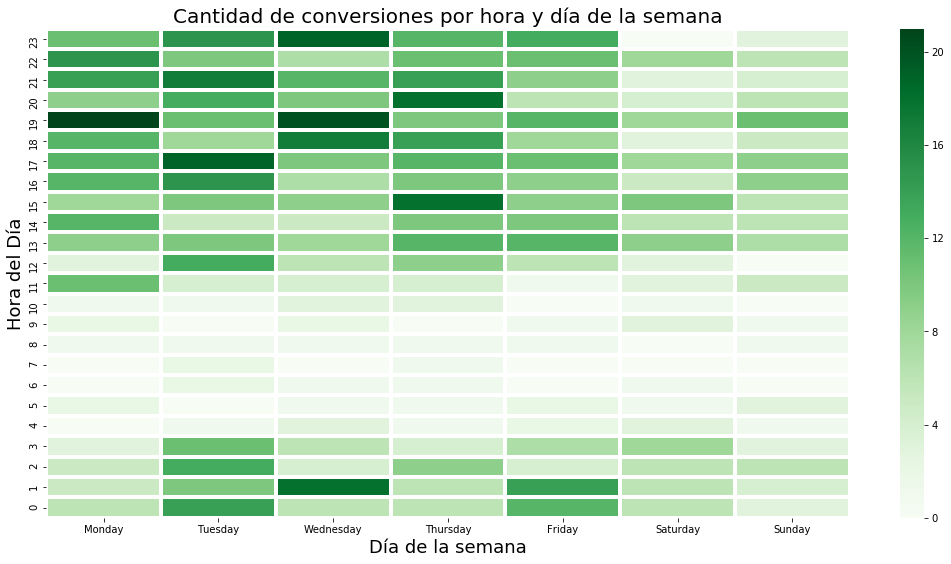

In [12]:
plot_heatmap(conversion,'Cantidad de conversiones por hora y día de la semana','Hora del Día','Día de la semana')

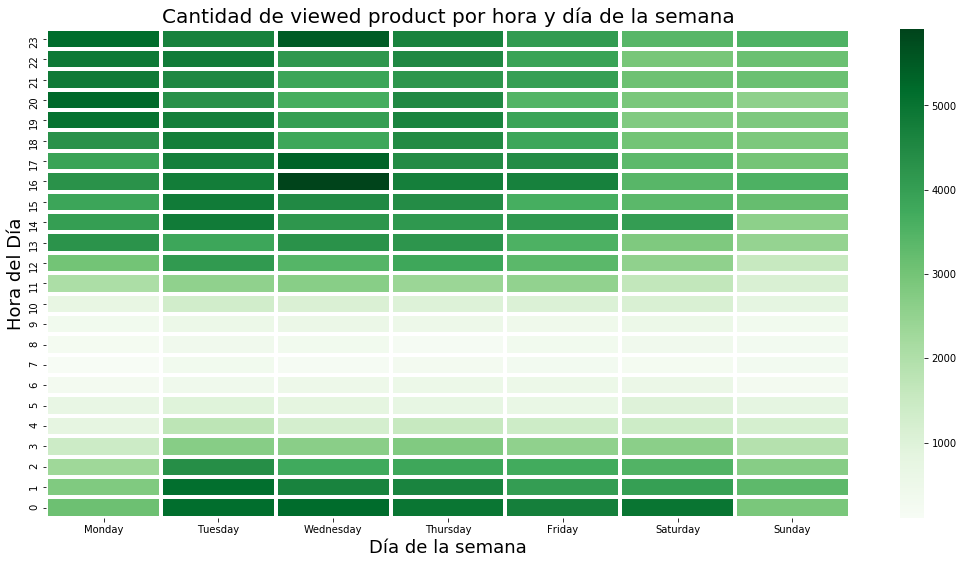

In [13]:
viewed = per_event_hour_weekday.loc['viewed product'].transpose()
viewed.sort_index(ascending=False,inplace=True)
plot_heatmap(viewed,'Cantidad de viewed product por hora y día de la semana','Hora del Día','Día de la semana')

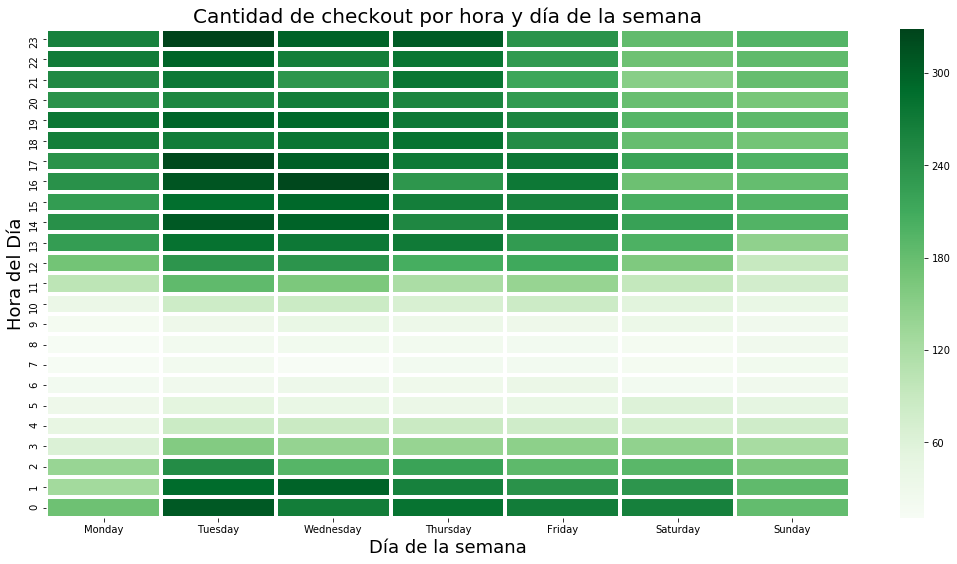

In [14]:
checkout = per_event_hour_weekday.loc['checkout'].transpose()
checkout.sort_index(ascending=False,inplace=True)
plot_heatmap(checkout,'Cantidad de checkout por hora y día de la semana','Hora del Día','Día de la semana')

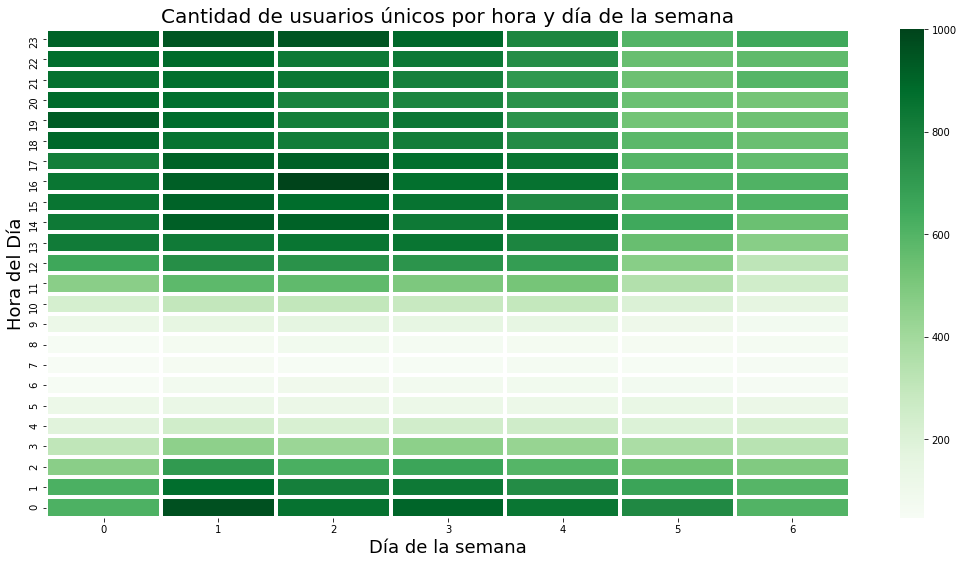

In [15]:
#todos los eventos, usuarios únicos
per_date_total = events.groupby(['weekday','hour']).agg({'person':'nunique'}).unstack()
per_date_total.columns = per_date_total.columns.droplevel(0)
per_date_total.fillna(value=0,inplace=True)
per_date_total = per_date_total.astype(dtype='int64')
unique_users = per_date_total.transpose()
unique_users.sort_index(ascending=False,inplace=True)
plot_heatmap(unique_users,'Cantidad de usuarios únicos por hora y día de la semana','Hora del Día','Día de la semana')

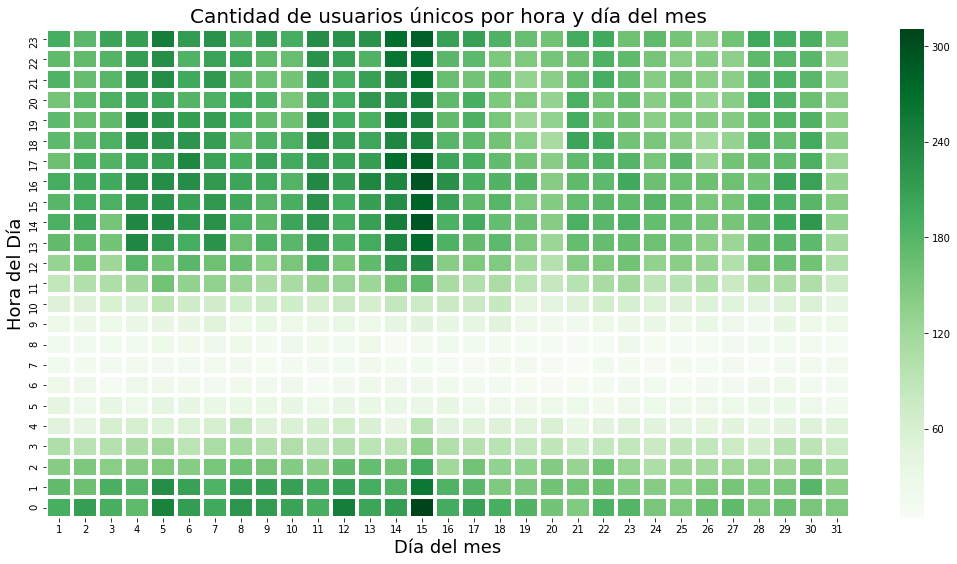

In [16]:
heatmap_unique_users_between_dates()

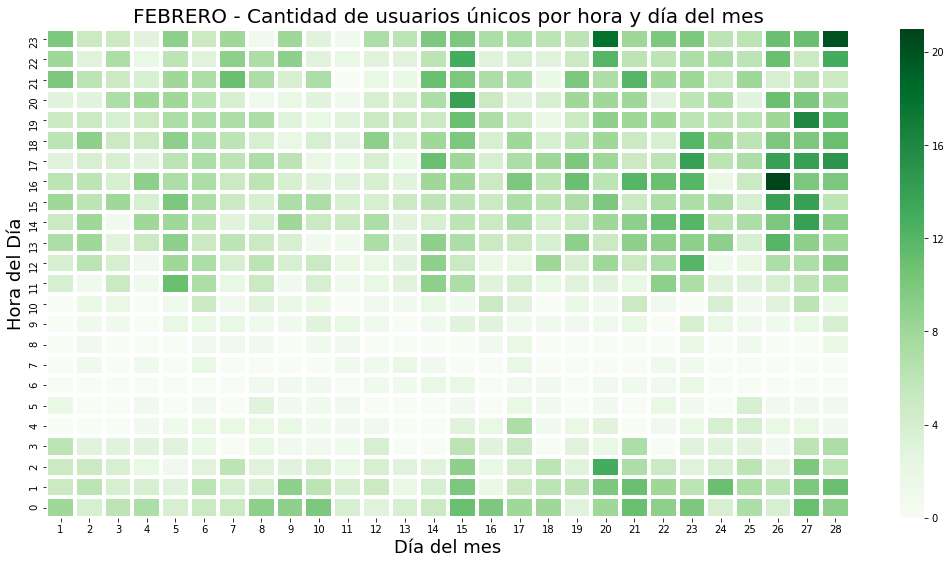

In [17]:
heatmap_unique_users_between_dates(desde='2018-02-01 00:00:00',hasta='2018-03-01 00:00:00',title='FEBRERO - Cantidad de usuarios únicos por hora y día del mes')

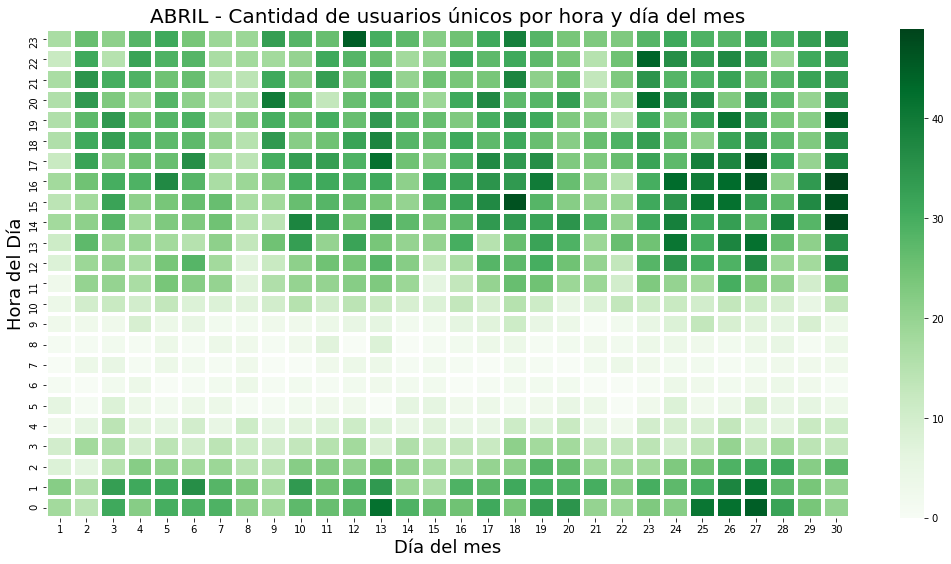

In [18]:
heatmap_unique_users_between_dates(desde='2018-04-01 00:00:00',hasta='2018-05-01 00:00:00',title='ABRIL - Cantidad de usuarios únicos por hora y día del mes')

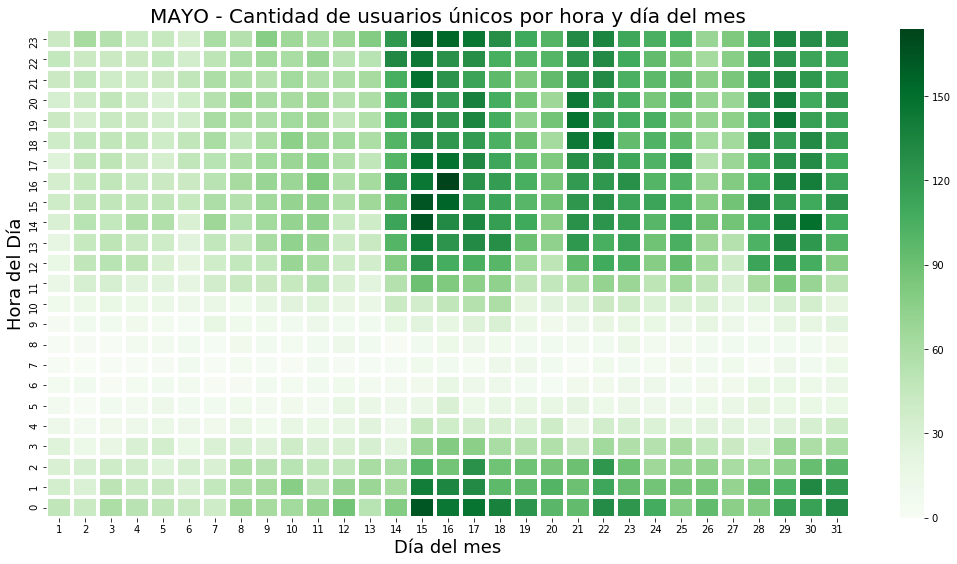

In [19]:
heatmap_unique_users_between_dates(desde='2018-05-01 00:00:00',hasta='2018-06-01 00:00:00',title='MAYO - Cantidad de usuarios únicos por hora y día del mes')

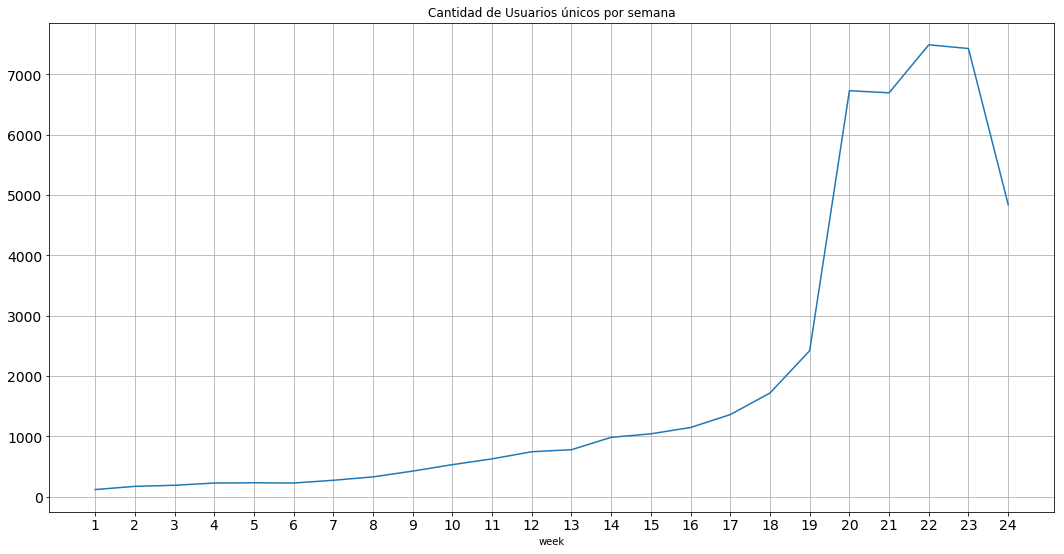

In [20]:
per_week_total_unique = events.groupby(['week']).agg({'person':'nunique'}).unstack()
per_week_total_unique.index = per_week_total_unique.index.droplevel(0)
logy = False
graph = per_week_total_unique.plot(logy=logy,figsize=(18,9),grid=True,title='Cantidad de Usuarios únicos por semana',fontsize=14,xticks=per_week_total_unique.index)

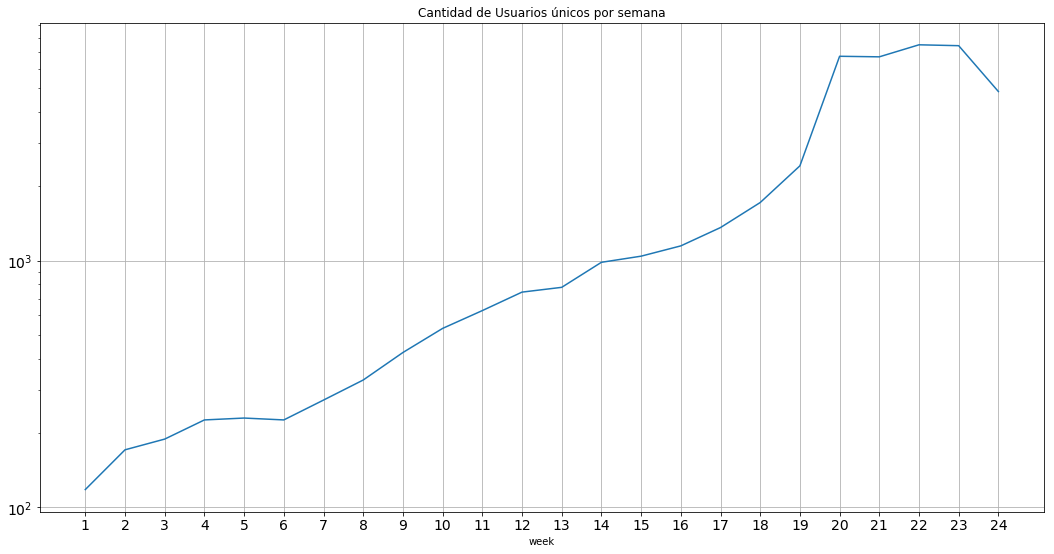

In [21]:
logy = True
graph = per_week_total_unique.plot(logy=logy,figsize=(18,9),grid=True,title='Cantidad de Usuarios únicos por semana',fontsize=14,xticks=per_week_total_unique.index)

A partir del gráfico anterior, podemos determinar que durante la semana 20 (mayo) el tráfico en el sitio aumentó estrepitosamente.
Al graficar con escala logarítmica notamos que este crecimiento abrupto se estanca y para la última semana de la que se disponen datos llega a niveles similares a los que hubiera tenido si continuaba con la misma pendiente de crecimiento (exponencial) que tenìa hasta el punto de quiebre de la semana.
En otro notebook se analizarán las causas y características de este crecimiento.